@patrick

# Machine Learning

Dieses Notebook beinhaltet die Prüfungsleistung im Kurs WWI18SEA/C für Machine Learning bei Frau Minges. Es wurde erstellt von Patrick Mischka, Jan Grübener, Matthias Vonend, Aaron Schweig, Michael Angermeier und Troy Keßler.

Hinweis: Alle Sektionen, welche mit @ annotiert sind, sind lediglich Einteilungen für die Präsentation und stellen nicht die Leistung der Personen dar.

## Inhalt

Ziel ist mithilfe von Machine Learning eine Trading Recommendation für Ethereum zu entwickeln. Diese soll aus zwei Teilen bestehen, zum einen aus einer technischen Analyse, wo ein LSTM Modell unter Verwendung von historischen Preisen und Indikatoren entwickelt und trainiert wird, und zum Anderen aus einer Stimmungsanalyse auf Twitter, wofür ein weiteres Deep Neural Network entwickelt und trainiert wird. Letztendlich sollen die Ergebnisse dieser Modelle Entscheidungshilfen sein, um Ethereum zu handeln.

### 1. Sentimentmodell

Im ersten Teil wird ein Sentimentmodell entwickelt und trainiert. Das Ziel ist hier ein Modell zu entwickelt, welches Tweets auf ihre Stimmung bewerten kann.

### 2. Technisches Modell

Im zweiten Teil wird ein technisches Modell entwickelt und trainiert. Das Ziel ist hier, basierend auf historischen Preisverläufen und anderen technischen Indikatoren, den zukünftigen Preis für die nächsten 30 Tage vorherzusagen.

### 3. Ausführung

Im dritten und letzten Teil werden die Modelle an APIs angeschlossen, so dass die Entscheidungshilfen live ausgeführt werden können.

## Technologien

Für das Modell wird [Tensorflow](https://www.tensorflow.org/) verwendet, zum Plotten von Informationen nutzen wir [Matplotlib](https://matplotlib.org/stable/index.html) und zum Verarbeiten von Daten [Pandas](https://pandas.pydata.org/). Außerdem werden weitere Utilities von [sklearn](https://scikit-learn.org/stable/) übernommen.

## Setup

Um dieses Notebook zu benutzen müssen Python 3.x (vorzugsweise 3.7.3) und folgende Packages installiert werden:

* tensorflow==2.4.1
* matplotlib==3.0.3
* pandas==1.2.2
* pandas_datareader==0.9.0
* searchtweets-v2==1.0.7
* sklearn

Das Datenset für das Trainieren kann über [diesen Link](https://www.dropbox.com/s/ur7pw797mgcc1wr/tweets.csv?dl=0) heruntergeladen werden. Dabei muss die Datei "tweets.csv" in den gleichen Ordner wie dieses Notepad abgelegt werden.


## 1. Sentimentmodell

In diesem Notebook wird ein Modell trainiert, welches Tweets live auf ihre Stimmung bewerten soll. Dafür wird ein Deep Neural Network erstellt, welches mit 1.6 Millionen Tweets trainiert wird. Hierbei handelt es sich um ein Klassifikationsproblem, es soll letztendlich entschieden werden, ob ein Tweet negativ (0), oder positiv (1) gestimmt ist.

### Datensatz

Um nun das Modell möglichst gut darauf zu trainieren reale Tweets zu bewerten haben wir uns für ein Datenset entschieden, welches 1.6 Millionen bereits gelabelte Tweets enthält. Dieses Datenset kann [hier](https://www.kaggle.com/kazanova/sentiment140) gefunden werden.

In [22]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tensorflow import feature_column

### Laden des Datensatzes

Mithilfe von pandas wird das Datenset geladen. Dabei werden nur die erste und die letzte Spalte geladen, da nur diese für uns von Interesse sind. Da es sich bei der ersten Spalte um die Stimmung des Tweets handelt, wird diese mit "targets" gelabelt. Die letzte Spalte beinhaltet den eigentlichen Tweet, welcher mit "text" gelabelt wird.

In [2]:
dataframe = pd.read_csv("./tweets.csv", usecols=[0, 5], names=["target", "text"])

Da das Datenset sortiert ist, muss es randomisiert werden. Falls dies nicht gemacht werden würde, hätte dies einen negativen Einfluss auf das Lernen. Zuerst würden alle negativ gelabelten Daten geladen werden, wodurch das Modell "denkt", dass alle Daten negativ wären. Das Modell würde sich entsprechend darauf einstellen. Werden positiven Daten verwerdet, würde das Modell annehmen, dass es nur positive Daten gäbe. Dementsprechend würde es bei richtigen (nicht-trainings) Daten immer eine positive Stimmung vorhersagen, was aber nicht der Realtität entsprechen würde.

In [3]:
dataframe = shuffle(dataframe)

Wenn der Datensatz korrekt geladen wurde sollte eine Tabelle mit den ersten fünf Einträgen zu sehen sein.

In [4]:
dataframe.head()

,target,text
792586,0,school but last day =D
397018,0,awe my laptop died yay for blackberrys!
124537,0,"@BATMANNN awwwwwh well, just try and forget a..."
712067,0,just left Texas now in new Mexico here we com...
734459,0,@BabeNatasha and spanish and write up journals...


Um das Trainieren des Modells zu überwachen und um die Trefferquote des Modells hinterher zu errechnen wird der Datensatz in drei Teile unterteilt. In einem Verhältnis von 80:20 wird der Datensatz in Trainingsdaten und Testdaten unterteilt. Trainingsdaten dienen hier ausschließlich zum Trainieren des Modells. Die Testdaten werden nach dem Trainieren dazu verwendet, um die Trefferquote des Modells zu errechnen. Diese sollen reale Daten simulieren. Dieses Verhältnis wurde gewählt, da mehr Trainingsdaten ein besseres Ergebnis versprechen. Die Anzahl der Testdaten muss hingegen nicht hoch sein, um die Trefferquote zu bestimmen.

Weiterhin werden die Trainingsdaten wiederum in Trainingsdaten und Validierungsdaten aufgeteilt. Auch hier wird ein Verhältnis von 80:20 angesetzt. Die Validierungsdaten werden dazu verwendet, um das Training zu überwachen. Nach jeder Epoche (Trainingsschritt) wird damit die aktuelle Trefferquote bestimmt.

In [5]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'training tweets')
print(len(val), 'validation tweets')
print(len(test), 'test tweets')

1024000 training tweets
256000 validation tweets
320000 test tweets


Da jetzt der Datensatz entsprechend aufgeteilt wurde, kann er nun in das Tensorflow-Format gebracht werden. Dafür werden die Features (text) und die Labels (labels) klar definiert. Zusätzlich wird eine Batchgröße definiert, welche Daten gruppiert und dadurch das Lernen beschleunigt.

In [6]:
def df_to_dataset(dataframe, batch_size):
  dataframe = dataframe.copy()
  texts = dataframe.pop('text')
  labels = dataframe.pop('target')
  return tf.data.Dataset.from_tensor_slices((texts, labels)).batch(batch_size)

In [7]:
batch_size = 320

raw_train_ds = df_to_dataset(train, batch_size)
raw_val_ds = df_to_dataset(val, batch_size)
raw_test_ds = df_to_dataset(test, batch_size)

Um zu validieren, dass die Konvertierung erfolgreich war, werden die ersten drei Einträge ausgelesen.

In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Tweet:", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Tweet: b'@deannetheresa I hope things are okay, dear  xoxo'
Label: 0
Tweet: b'drip drip drop little april showers '
Label: 4
Tweet: b'@xxandip mine too  diversity HAS to win'
Label: 4


@matthias

Um unnötige Duplikate zu vermeiden, werden die Daten für das Modell normalisiert. Beispielsweiße werden Wörter, die in manchen Tweets groß und in anderen wieder klein geschrieben werden, angepasst. Zusätzlich können User-Namen, welche mit "@" beginnen normalisiert werden, da der genaue User-Name unwichtig für die Sentiment-prediction ist.

In [9]:
def normalize_data(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase, '@(\w*)|(\\n)|(https:\/\/t\.co[\w\/]*)', '')

Nun können die Texte vektorisiert werden. Da ein neuronales Netz nicht mit Wörtern und Buchstaben arbeiten kann, müssen diese in Zahlen umgewandelt werden. Dafür werden die Tweets in Vektoren umgewandelt. Die Größe des Vektors wird dabei mit sequence_length definiert. Die Größe der sequence_length, also die Größe des Vektors, sollte in der Regel so groß sein, dass alle Wörter eines Tweets hineinpassen. Da die Anzahl an Zeichen auf 280 pro Tweet limitiert ist, und die durchnittliche Anzahl der Zeichen pro Wort im Englischen bei 5 liegt, wird die sequence_length mit 56 definiert.

Hier erhält jedes Wort eine fortlaufende Id. Die Reihenfolge dieser Ids ist durch die Reihenfolge in dem die Wörter vektorisiert wurden festgelegt. Dabei können aufgrund max_features maximal 10000 Wörter eingelesen werden. Alle weiteren Wörter werden ignoriert. Diese Menge an Vokabeln sollte aber ausreichen, da in der Alltagssprache lediglich zwei- bis dreitausend Wörter verwendet werden. Somit kann jedes Wort einer Id zugewiesen werden, sodass man ganze Sätze in einem Vektor abbilden kann. Da die Vektorengröße immer der sequence_length enstpricht, wird auch das Problem, dass ein neuronales Netz immer die gleiche Inputgröße benötigt, gelöst.

Dafür wird hier ein Vektorlayer erstellt. Gleichzeitig können hier die Daten normalisiert werden.

In [10]:
max_features = 10000
sequence_length = 56

vectorize_layer = TextVectorization(
    standardize=normalize_data,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Hier werden die Trainingsdaten eingelesen, so dass die 10000 Features gefüllt werden können. Es entsteht ein "Wörterbuch" für Tweets

In [11]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Mit der Methode können wir alle Datensätze vektorisieren. Hier normalisieren wir das Label, so dass das Label eine Wertebereich von 0 bis 1, anstatt von 0 bis 4 besitzt. 

In [12]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), int(label / 4)

Um zu testen, ob das Vektorisieren der Tweets funktioniert, können wir den ersten Tweet aus dem ersten Batch auslesen und vektorisieren.

In [13]:
text_batch, label_batch = next(iter(raw_train_ds))
text, label = text_batch[0], label_batch[0]
print(text)
print(label)
print(vectorize_text(text, label))

tf.Tensor(b'@deannetheresa I hope things are okay, dear  xoxo', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
(<tf.Tensor: shape=(1, 56), dtype=int64, numpy=
array([[   2,   88,  241,   30, 1166,  858, 1012,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int64)>, 0)


Mithilfe des Vektorlayers können wir von den Ids wieder auf die Wörtern zurückschließen. Außerdem können wir die Größe unseres Wörterbuchs auslesen.

In [14]:
print("1234 ---> ", vectorize_layer.get_vocabulary()[1234])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1234 --->  exciting
Vocabulary size: 10000


Nun vektorisieren wir alle benötigten Datensätze.

In [15]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Aus Performancegründen können die Datensätze weiter aufbereitet werden. Mit `.cache()` bleiben die Daten im Arbeitsspeicher, nachdem diese von der Festplatte geladen wurden. Somit kann sichergestellt werden, dass das Laden der Daten nicht der Flaschenhals beim Training sein wird.

Mit `.prefetch()` können die Daten gleichzeitig mit dem Lernen präprozessiert werden.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Schließlich definieren wir das eigentliche Modell. Der erste Layer ist ein Embedding-Layer. Dieser sorgt dafür, dass jedes Wort einen eigenen Vektor erhält, welcher die Bedeutung des Wortes darstellt. Diese Vektoren werden mit dem Modell über die Zeit trainiert. Dieser Embedding-Layer fügt eine weitere Dimension zum Outputvektor hinzu. Hier definieren wir mit der embedding_dim die Größe der Layer, das bedeutet, dass es 32 Nodes pro Layer gibt.

Als nächster Layer wird `GlobalAveragePooling1D` verwendet. Dieser reduziert die Dimension wieder um 1 und verrechnet dabei alle Informationen, sodass keine Informationen verloren gehen. Der Outputvektor wird dabei wieder auf eine feste Länge normalisiert.

Anschließend folgt ein fully-connected 32 Dense-Layer. Hier wurde eine Dropoutrate festgelegt, um Overfitting zu verhindern. Das Ziel hier ist random ausgewählte Nodes auf 0 zu setzen, damit das anspassen der Weights der einzelnen Nodes beim Lernen gefördert wird.

Letztendlich wird der letzte Layer mit einem Dense Layer zu einer einzigen Node verknüpft. Diese hat dank der Sigmoid-Aktivierungsfunktion ein Intervall von 0 bis 1 und gibt das Ergenis aus.

Wir können nun noch mit `.summary()` das Modell verifizieren.

In [17]:
embedding_dim = 32

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320032    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 320,065
Trainable params: 320,065
Non-trainable params: 0
_________________________________________________________________


@troy

Für das Trainieren müssen noch ein paar Parameter definiert werden. Für die Berechnung des Fehlers (loss) verwenden wir die `BinaryCrossentropy` Funktion. Der Fehler gibt uns an, wie weit wir von der richtigen Prediction weg sind. Wir haben uns dafür entschieden, da wir einen sogenannten Binary Classifier haben, der uns eine Wahrscheinlichkeit von 0 bis 1 als Ergebnis gibt.

Weiterhin verwenden wir für den Optimierungsalgorithmus den `Adam-Optimizer`. Wir haben uns für den Adam-Optimizer, im Vergleich zum klassischen Stochastic-Gradient-Descent-Algorithmus entschieden, da sich die Learningrate beim Adam-Optimizer mit der Zeit automatisch anpasst. Das ist besonders praktisch bei Natural-Language-Processing, da hier die Gradients in der Regel sehr gering sind. Dabei wird die Learningrate basierend auf der vorherigen Änderung der Weights angepasst. Hier haben wir eine sehr kleine Learningrate definiert, da wir ein sehr großes Datenset haben und nicht zu schnell in das Problem von Overfitting laufen wollen.

Zusätzlich werden weitere Metriken wie True Positives, False Positives, True Negatives, False Negatives, Precision, Recall und AUC gemessen, um genauere Aussagen über die Genauigkeit des Modells zu treffen.

In [18]:
metrics = [
  tf.metrics.TruePositives(name='tp'),
  tf.metrics.FalsePositives(name='fp'),
  tf.metrics.TrueNegatives(name='tn'),
  tf.metrics.FalseNegatives(name='fn'), 
  tf.metrics.BinaryAccuracy(name='accuracy'),
  tf.metrics.Precision(name='precision'),
  tf.metrics.Recall(name='recall'),
  tf.metrics.AUC(name='auc'),
]

model.compile(loss=losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=metrics)

Nun wird das Modell trainiert. Dafür definieren wir mit epochs, wie oft wir über das Trainingsdatenset iterieren. In `model.fit()` werden die Trainingsdaten, die Validationsdaten und die Anzahl der Epochen angegeben. Tensorflow loggt den Fortschritt live in der Konsole aus und zusätzlich wird der Trainingsstatus in einem History-Objekt festgehalten.

In [19]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
3200/3200 [==============================] - 26s 8ms/step - loss: 0.6871 - tp: 180734.9303 - fp: 121461.9322 - tn: 134729.6913 - fn: 75393.3461 - accuracy: 0.5933 - precision: 0.5835 - recall: 0.6284 - auc: 0.6328 - val_loss: 0.6545 - val_tp: 95829.0000 - val_fp: 46293.0000 - val_tn: 81647.0000 - val_fn: 32231.0000 - val_accuracy: 0.6933 - val_precision: 0.6743 - val_recall: 0.7483 - val_auc: 0.7653
Epoch 2/10
3200/3200 [==============================] - 22s 7ms/step - loss: 0.6411 - tp: 192549.5348 - fp: 91421.7704 - tn: 164769.8532 - fn: 63578.7416 - accuracy: 0.6946 - precision: 0.6746 - recall: 0.7528 - auc: 0.7650 - val_loss: 0.6017 - val_tp: 96193.0000 - val_fp: 40336.0000 - val_tn: 87604.0000 - val_fn: 31867.0000 - val_accuracy: 0.7180 - val_precision: 0.7046 - val_recall: 0.7512 - val_auc: 0.7885
Epoch 3/10
3200/3200 [==============================] - 22s 7ms/step - loss: 0.5921 - tp: 193566.6373 - fp: 78835.7038 - tn: 177355.9197 - fn: 62561.6392 - accuracy: 0.7216 

In dem History-Objekt können wir nun sehen, welche Daten Tensorflow für uns aufgezeichnet hat.

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])

Mithilfe von Matplotlib können wir den Loss plotten und beobachten, wie sich diese während des Lernens verhalten hat. Optimalerweise sollte diese mit der Zeit sinken, da mit dem Anpassen der Weights das Modell immer genauere Aussagen treffen sollte und somit auch der Fehler immer geringer werden sollte.

Wir können erkennen, dass dies tatsächlich der Fall ist. Der Loss fällt fast exponentiell. Logischerweise wird der Trainingsloss immer geringer. Als Bestätigung für die Verbesserung des Modells dient hier der Validationloss. Dieser ist fast gleich, sodass wir davon ausgehen können, dass die Anzahl der Fehlinterpretierungen tatsächlich geringer wurde.

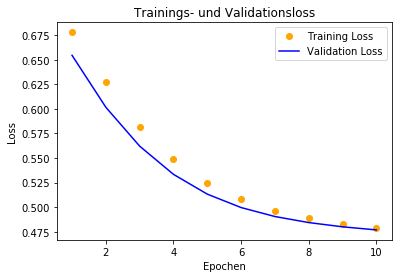

In [25]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'o', color='orange', label='Training Loss')
plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
plt.title('Trainings- und Validationsloss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()

plt.show()

Das Gleiche können wir auch für die Accuracy durchführen. Hier sollte im Optimalfall die Accuracy mit der Zeit steigen. Dieses Verhalten können wir wieder an unserem Modell erkennen. Hier erinnert der Graph an eine Sättigungskurve. Dies liegt daran, dass das Lernen letztendlich eine Optimierung ist und es mit der Zeit immer schwerer wird, das Modell noch mehr zu verbessern.

An beiden Graphiken kann man jedoch gut erkennen, dass es zu keinem Overfitting kommt. Wenn wir die Accuracy betrachten, würde bei Overfitting die Accuracy der Testdaten weiter ansteigen, während die Accuracy der Validationsdaten und die der Testdaten stagniert oder gar sinken. Das Gleiche würde analog mit dem Loss passieren.

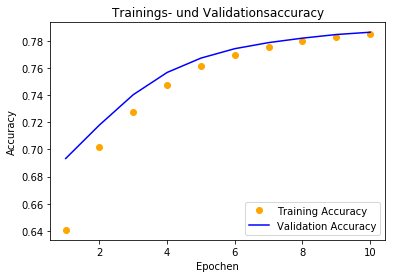

In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'o', color='orange', label='Training Accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
plt.title('Trainings- und Validationsaccuracy')
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Nachdem das Modell nun erfolgreich trainiert wurde können wir es mit den vorher festgelegten Testdatensatz testen. Zuerst extrahieren wir noch die Features und Labels aus den Datasets, um mit ihnen arbeiten zu können.

In [27]:
train_features = np.concatenate([x for x, y in train_ds], axis=0)
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

test_features = np.concatenate([x for x, y in test_ds], axis=0)
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

train_predictions_baseline = model.predict(train_features, batch_size=batch_size)
test_predictions_baseline = model.predict(test_features, batch_size=batch_size)

Mit den vorher gemessenen Metriken kann nun die Genauigkeit mithilfe einer Confusion-Matrix bestimmt werden. Hier wird ein Threshold von 0.5 verwendet, um die Anzahl an falschen Predictions insgesamt zu reduzieren. Dabei hat das Modell eine Testaccuracy von 78.23%, während die Präzision bei 76.93% und der Recall bei 80.43% liegt. Die Präzision sagt hier aus, dass 76.93% aller positiv predicteten Tweets tatsächlich positiv waren. Der Recall sagt hier, dass 80.43% aller positiven Tweets korrekt klassifiziert wurden.

Weiterhin beträgt die AUC 85.52% und da die Kurve über der Diagonale liegt ist das Modell besser als der Zufall.

loss :  0.4790298342704773
tp :  129218.0
fp :  38367.0
tn :  121516.0
fn :  30899.0
accuracy :  0.7835437655448914
precision :  0.7710594534873962
recall :  0.8070223927497864
auc :  0.8568227887153625

Negative Stimmung korrekt erkannt (True Negatives):  121516
Negative Stimmung falsch positiv erkannt (False Positives):  38367
Positive Stimmung falsch negativ erkannt (False Negatives):  30899
Positive Stimmung korrekt erkannt (True Positives):  129218


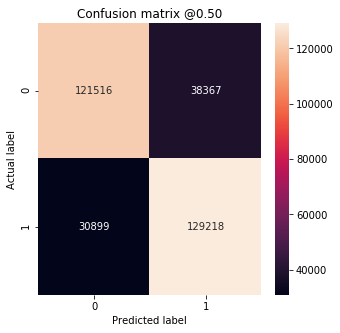

In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Negative Stimmung korrekt erkannt (True Negatives): ', cm[0][0])
  print('Negative Stimmung falsch positiv erkannt (False Positives): ', cm[0][1])
  print('Positive Stimmung falsch negativ erkannt (False Negatives): ', cm[1][0])
  print('Positive Stimmung korrekt erkannt (True Positives): ', cm[1][1])

baseline_results = model.evaluate(test_features, test_labels, batch_size=batch_size, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)

print()

plot_cm(test_labels, test_predictions_baseline)

Die ROC-Kurve beschreibt hier Confusion Matrizen mit unterschiedlichen Thresholds von 0 bis 1. Dabei wird insbesondere das Verhältnis zwischen True Positives und False Positives betrachtet.

(0,0) besagt, alle positiven Tweets wurden korrekt predicted, alle negativen falsch

(1,1) besagt, alle negativen Tweets wurden korrekt predicted, alle positiven falsch

Wie bereits erwähnt beträgt die AUC 85.52% und da die Kurve über der Diagonale liegt ist das Modell besser als der Zufall, sowohl im Training, als auch im Test.

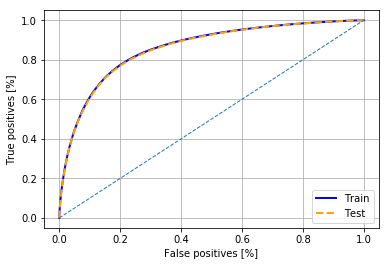

In [29]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)

plot_roc("Train", train_labels, train_predictions_baseline, color='b')
plot_roc("Test", test_labels, test_predictions_baseline, color='orange', linestyle='--')
plt.plot([0, 1], linewidth=1, linestyle='--')
plt.legend(loc='lower right')
plt.show()

Nun exportieren wir das fertige Modell. Da wir vorher die Texte vektorisiert haben, bevor sie in das Modell gegeben wurden, können wir hier ein Modell exportieren, welche die Texte beim Input vektorisiert. Dies macht uns das zukünftige Predicten einfacher, da das Model nicht immer neu trainiert werden muss. Zusätzlich fügen wir am Ende eine weitere Node mit einer Sigmoid Aktivierungsfunktion hinzu. Diese bildet alle Werte auf Werte zwischen 0 und 1 ab, sodass unsere definiert Sentiment-Range eingehalten wird. Der Vektorisationlayer und die Sigmoid Node wurden beim Lernen vernachlässigt, damit die Lerneffizienz höher ausfällt.

In [30]:
sentiment_model = tf.keras.Sequential([
  vectorize_layer,
  model
])

Schließlich können wir einige Beispiele eingeben, um zu sehen, wie sich das Modell verhält. Dabei ist der erste Satz positiv, der zweite neutral und der letzte negativ. Während der neutrale Satz mit rund 0.5 gewertet wird, wird der positive höher gewertet und der negative geringer.

In [31]:
examples = [
  "Today is a great day!",
  "This sentence is rather neutral",
  "This show is terrible!"
]

sentiment_model.predict(examples)

array([[0.8538385 ],
       [0.52383393],
       [0.45286494]], dtype=float32)

@jan

## 2. Technisches Modell

Bei dem zweiten Modell soll mithilfe von Finanzdaten eine Progrose erstellt werden, wie der Kursverlauf in den nächsten 30 Tagen sein wird. Für diese Progrose wird ein LSTM-Modell verwendet. Die Prognose wird anhand von des Kurses von Etherium zum US-Dollar aufgebaut. 

### Datensatz

Die Daten zum Trainieren des Modelles werden von Yahoo abgefragt. Bei diesen Daten handelt es sich stets um den "Closing Price", also den Preis, den Etherium am Ende eines Tages hatte. Diese Preise werden bis in das Jahr 2015 geladen. Dies entspricht insgesamt ca. 2000 Preisdaten. Zusätzlich zu den Preisdaten werden mithilfe von der "Technical Analysis Library" verschiedene technische Indikatoren berechnet. Anhand von diesen Indikatoren soll das Modell trainiert werden den Preis vorherzusagen.  

In [57]:
import pandas_datareader.data as pdr

from sklearn.preprocessing import MinMaxScaler
import random

from datetime import datetime, timezone,timedelta
from ta.utils import dropna
from ta.volatility import BollingerBands, AverageTrueRange
from ta.momentum import KAMAIndicator, PercentagePriceOscillator, PercentageVolumeOscillator, ROCIndicator, RSIIndicator, StochasticOscillator
from ta.trend import MACD, ADXIndicator, AroonIndicator
from ta.volume import OnBalanceVolumeIndicator, AccDistIndexIndicator

### Laden und generieren der Daten
Im Folgenden werden die Preisdaten von Etherium von 2015 bis heute geladen. Anschließend werden 7 technische Indikatoren generiert und dem Datensatz hinzugefügt. Diese Indikatoren sind:

* Kama
* Percentage Price Oscillator
* Rate of Change
* Moving Average Convergence/Divergence
* Relative Strength Index
* Aaron Indicator
* Bollinger bands

Zusätzlich werden der Tag des Monats, der Tag der Woche und der Monat als eigene Indikatoren hinzugefügt. Dies ist sinnvoll, da hier ein LSTM-, also ein Zeitreihen-Modell verwendet wird. Die Zeit spielt eine wichtige Rolle, um Besonderheiten an beispielsweise dem ersten Tag eines Monats erkennen zu können. Außerdem werden die Daten nicht gemischt, da sonst der zeitliche Verlauf verloren geht.

In [58]:
batch_size = 31
symbol = 'ETH-USD'

end = datetime.today()
start = datetime(2000, 9, 1)
ETH = pdr.DataReader(symbol,'yahoo',start,end)

df = pd.DataFrame(data=ETH)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-06,3.536610,2.521120,2.831620,2.772120,1.643290e+05,2.772120
2015-08-07,2.798810,0.714725,2.793760,0.753325,6.741880e+05,0.753325
2015-08-08,0.879810,0.629191,0.706136,0.701897,5.321700e+05,0.701897
2015-08-09,0.729854,0.636546,0.713989,0.708448,4.052830e+05,0.708448
2015-08-10,1.131410,0.663235,0.708087,1.067860,1.463100e+06,1.067860
...,...,...,...,...,...,...
2021-04-08,2102.873779,2055.163330,2088.772217,2072.108887,1.981247e+10,2072.108887
2021-04-09,2196.996338,2062.787598,2071.111572,2135.942139,2.498624e+10,2135.942139
2021-04-10,2165.191406,2119.865723,2136.156982,2157.656982,1.969284e+10,2157.656982


In [59]:
kama_indicator = KAMAIndicator(close = df["Close"], window = 10, pow1 = 2, pow2 = 30, fillna = False)
df['kama'] = kama_indicator.kama()
ppo_indicator = PercentagePriceOscillator(close = df["Close"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
df['ppo'] = ppo_indicator.ppo()
roc_indicator = ROCIndicator(close = df["Close"], window = 12, fillna = False)
df['roc'] = roc_indicator.roc()
macd_indicator = MACD(close = df["Close"], window_slow = 20, window_fast = 12, window_sign = 9, fillna = False)
df['macd'] = macd_indicator.macd()
rsi_indicator = RSIIndicator(close = df["Close"], window = 14, fillna = False)
df['rsi'] = rsi_indicator.rsi()
aroon_indicator = AroonIndicator(close = df["Close"], window = 20, fillna = False)
df['aroon'] = aroon_indicator.aroon_indicator()
boll_indicator = BollingerBands(close = df["Close"], window = 20, window_dev = 2, fillna = False)
df['boll_mavg'] = boll_indicator.bollinger_mavg()
df.rename(columns = {"Close": "price"}, inplace=True)
prices = df['price'].to_numpy()

df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

df.dropna(inplace=True)
df = df.drop(df.columns[[0, 1, 2, 4, 5]], axis=1)
df

,price,kama,ppo,roc,macd,rsi,aroon,boll_mavg,day_of_month,day_of_week,month
Date,,,,,,,,,,,
2015-08-25,1.159980,1.405750,-13.445239,-36.539248,-0.166625,35.737493,-10.0,1.340227,25,1,8
2015-08-26,1.147700,1.402955,-13.377194,-32.044529,-0.162148,35.483536,25.0,1.259006,26,2,8
2015-08-27,1.191380,1.398493,-12.841273,-23.923552,-0.153785,37.193189,25.0,1.280909,27,3,8
2015-08-28,1.182550,1.394309,-12.305072,-1.749735,-0.145647,36.979851,20.0,1.304942,28,4,8
2015-08-29,1.319270,1.390506,-10.768333,21.362409,-0.129269,42.481178,15.0,1.335483,29,5,8
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-08,2072.108887,1991.376608,4.081519,22.511697,60.937251,59.999725,45.0,1882.091046,8,3,4
2021-04-09,2135.942139,1999.267442,4.168943,17.379778,62.985439,62.776708,45.0,1899.477301,9,4,4
2021-04-10,2157.656982,2006.371884,4.245169,16.880694,64.903268,63.699943,90.0,1922.793451,10,5,4


Im Folgenden ist nun einmal der gesamt geladene Kursverlauf Etherium zu sehen.

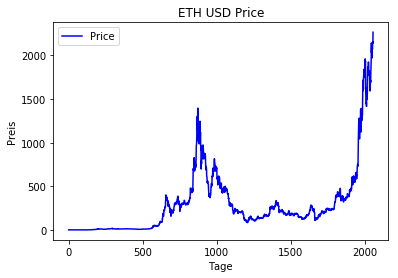

In [60]:
prices = df['price'].to_numpy()
days = range(1, len(prices) + 1)

plt.plot(days, prices, 'blue', label='Price')
plt.title('ETH USD Price')
plt.xlabel('Tage')
plt.ylabel('Preis')
plt.legend()

plt.show()

### Aufteilung in Features und Labels
Die Daten werden in Features und Labels aufgeteilt. In diesem Fall sind die Spalten, welche in `X_columns` definiert sind, die Features und der Preis das Label. 

In [61]:
X_columns = ['price', 'kama', 'ppo', 'roc', 'macd', 'rsi', 'aroon', 'boll_mavg', 
                   'day_of_month', 'day_of_week', 'month']

X_data = df.filter(X_columns)
y_data = df.filter(['price'])

print(X_data.shape)
print(y_data.shape)

(2054, 11)
(2054, 1)


### Transformation der Daten
Für die Transformation der Daten wird der MinMaxScaler verwendet. Dieser skaliert die Daten in einen vorgegebenen Bereich und macht die Daten damit praktikabel. In diesem Fall werden alle Daten in einem Bereich zwischen 0 und 1 skaliert.

In [62]:
X_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

X_scaled_data = X_scaler.fit_transform(X_data)
y_scaled_data = y_scaler.fit_transform(y_data)

X_scaled_data = pd.DataFrame(data=X_scaled_data, index=X_data.index, columns=X_columns)
y_scaled_data = pd.DataFrame(data=y_scaled_data, index=y_data.index, columns=['price'])

X_scaled_data

,price,kama,ppo,roc,macd,rsi,aroon,boll_mavg,day_of_month,day_of_week,month
Date,,,,,,,,,,,
2015-08-25,0.000320,0.000413,0.087378,0.076386,0.333897,0.257724,0.447368,0.000390,0.800000,0.166667,0.636364
2015-08-26,0.000315,0.000412,0.089021,0.097446,0.333924,0.254459,0.631579,0.000349,0.833333,0.333333,0.636364
2015-08-27,0.000334,0.000410,0.101965,0.135497,0.333973,0.276440,0.631579,0.000360,0.866667,0.500000,0.636364
2015-08-28,0.000330,0.000407,0.114915,0.239393,0.334021,0.273698,0.605263,0.000372,0.900000,0.666667,0.636364
2015-08-29,0.000390,0.000406,0.152030,0.347686,0.334117,0.344430,0.578947,0.000388,0.933333,0.833333,0.636364
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-08,0.914596,0.980690,0.510678,0.353071,0.694194,0.569672,0.736842,0.950808,0.233333,0.500000,0.272727
2021-04-09,0.942777,0.984577,0.512790,0.329025,0.706271,0.605376,0.736842,0.959594,0.266667,0.666667,0.272727
2021-04-10,0.952364,0.988076,0.514631,0.326686,0.717580,0.617247,0.973684,0.971376,0.300000,0.833333,0.272727


Um das Modell trainieren zu können, müssen zunächst die Daten in batches unterteilt werden und danach die batches vermischt werden. 

In [63]:
X_scaled_batches = []
y_scaled_batches = []

for i in range(len(X_scaled_data) - batch_size - 1):
    X_scaled_batches.append(X_scaled_data.iloc[i:(i+batch_size)].values)
    y_scaled_batches.append(y_scaled_data.iloc[i+batch_size + 1])


In [64]:
mixed = list(zip(X_scaled_batches, y_scaled_batches))

random.shuffle(mixed)

X_random_batches, y_random_batches = zip(*mixed)

Die gesammelten Daten müssen im nächsten Schritt in Traings- und Testdaten aufgeteilt werden. Dafür wurde die Aufteilung von 90% zu 10% gewählt (90% Traningsdaten und 10% Testdaten). Beide Datensätze haben immernoch die gleiche Anzahl an Spalten, die Zeilen wurden entsprechend der genannten Aufteilung gesplittet.

In [65]:
train_size = int(len(X_scaled_batches) * 0.9)
test_size = len(X_scaled_batches) - train_size
X_train_random, X_test_random = X_random_batches[0:train_size], X_random_batches[train_size:len(X_scaled_batches)]
y_train_random, y_test_random = y_random_batches[0:train_size], y_random_batches[train_size:len(y_scaled_batches)]

X_train_random = np.array(X_train_random)
X_train_random = np.reshape(X_train_random, (X_train_random.shape[0], X_train_random.shape[1], X_train_random.shape[2]))
y_train_random = np.array(y_train_random)

X_test_random = np.array(X_test_random)
X_test_random = np.reshape(X_test_random, (X_test_random.shape[0], X_test_random.shape[1], X_test_random.shape[2]))
y_test_random = np.array(y_test_random)


In [66]:
X_train, X_test = X_scaled_batches[0:train_size], X_scaled_batches[train_size:len(X_scaled_batches)]
y_train, y_test = y_scaled_batches[0:train_size], y_scaled_batches[train_size:len(y_scaled_batches)]

X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
y_train = np.array(y_train)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
y_test = np.array(y_test)

X_train_random.shape

(1819, 31, 11)

@michael

### Modell erstellen
Bei diesem Anwendungsbeispiel ist das Ziel den Kursverlauf anhand von Indikatoren und Preisen aus der Vergangenheit für die Zukunft vorherzusagen. Im Detail werden 11 Kennzahlen für jeden der letzten 30 Tage verwendet, um den Preis für morgen vorherzusagen.

Damit das Ziel erreicht werden kann, wird ein LSTM(long short-term memory)-Modell verwendet. Dieses Modell ist eine Erweiterung zu dem RNN(recurrent neural network)-Modell. Das LSTM-Modell im spezielle ist dafür ausgelegt in Zeitreihen oder anderen zusammenhängenden Datensätzen bestimmte Sequenzen zu erkennen. Neugewonnene Informationen können dabei gespeichert werden, um bei zukünftigen Zeitreihen angewandt zu werden. Außerdem kann ein LSTM-Modell entscheiden, ob eine Zeitreihe wichtige Informationen enthält oder nicht und diese dann entweder vergessen oder aktualisieren.
Für das LSTM-Modell werden folgende Parameter definiert: 

* `units = 15` (passende Anzahl für die Menge an Daten; bei höherer Anzahl --> Overfitting)
* `return_sequences = False` (Nur eine LSTM-layer --> False)
* `input_shape = 31, 11` (Diese Zahlen spiegel die Form der Inputdaten wider; 31: batch_size; 11: Anzahl der Indikatoren) 

Anschließend wird für Dropout bestimmt wie viel Prozent der Neuronen pro Durchlauf "ausgeschaltet" sind, um die Gefahr von Overfitting zu vermeiden.

Der letzte Bestandtteilt ist die Dense Layer. Dort wird das Outputformat definiert. Die Anzahl an `units` entspricht in diesem Beispiel 1, da nur der Preis für morgen verhergesagt werden soll. Sollten beispielsweise die Preise für die nächsten 3 Tage vorhergesatz werden, müsste die Dense-layser mit 3 definiert werden.  

In der `model.summary` können nochmal die Daten überprüft werden.

In [67]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units = 15, return_sequences = False, input_shape = (X_train_random.shape[1], X_train_random.shape[2])))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 15)                1620      
_________________________________________________________________
dropout_3 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 1,636
Trainable params: 1,636
Non-trainable params: 0
_________________________________________________________________


### Modell trainieren
Für das Modell wird zum einen der `adam`-Optimierer und zum anderen die `mean_squared_error` loss-Funktion genutzt.

Für den `adam`-Optimierer haben wir uns, wie bereits oben beschrieben, entschieden, weil sich die Learningrate mit der Zeit automatisch anpasst und somit die Weights verbessert. Die Learningrate wurde hier nicht angepasst und ist damit standardmäßig auf 0,001 eingestellt. Dies ist möglich, da bei diesem Modell nicht so viele Daten zur Verfügung stehen und damit das Problem des Overfittings hier nicht eintritt.

Die loss-Funktion `mean_aquared_error` ist für diesen Anwendungsfall sehr geeignet, weil die es bei diesem Modell darum geht, möglichst nahe an den tatsächlichen Output zu kommen. Mit dieser Funktion wird als Gundidee immer der vorhergesagte Output von dem tatsächlichen Output abzogen und davon das Quadrat benutzt. Damit kann bei diesem LSTM-Modell ein sehr niedriger loss-Wert erreicht werden. 

In [68]:
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    X_train_random, y_train_random,
    epochs=30,
    validation_split=0.1,
)

Epoch 1/30
52/52 [==============================] - 2s 15ms/step - loss: 0.0766 - val_loss: 0.0119
Epoch 2/30
52/52 [==============================] - 0s 8ms/step - loss: 0.0201 - val_loss: 0.0038
Epoch 3/30
52/52 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.0022
Epoch 4/30
52/52 [==============================] - 1s 10ms/step - loss: 0.0087 - val_loss: 0.0014
Epoch 5/30
52/52 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0011
Epoch 6/30
52/52 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 8.5012e-04
Epoch 7/30
52/52 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 7.3449e-04
Epoch 8/30
52/52 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 7.8060e-04
Epoch 9/30
52/52 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 6.6498e-04
Epoch 10/30
52/52 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 4.8950e-

Die loss-Rate sollte bei einem Modell immer so gering wie nur möglich sein. In dem folgendem Diagramm ist gut zu sehen, dass die loss-Rate in den ersten Epochen noch relativ hoch war und sich dann immer mehr einer Zahl nahe 0,0015 angegelichen hat. Die Rate wurde dann auch ziemlich konstant über die restlichen Epochen gehalten. 

In [69]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

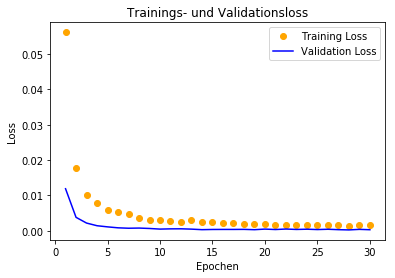

In [70]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'o', color='orange', label='Training Loss')
plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
plt.title('Trainings- und Validationsloss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Überprüfung des Modells
Nachdem das Modell nun trainiert ist, kann zunächst überprüft werden, wie das Modell mit den Trainingsdaten performed. In dem ersten Diagramm sind alle Trainingsdaten abgebildet. Im zweiten Diagramm sind die Vorhersagen des ersten Jahres und im letzten Diagramm die Vorhersagen des letzten Jahres eingezeichnet. Dort ist gut zu erkennen, dass im ersten Jahr die Vorhersage noch sehr ungenau ist und große Schwankungen enhält. Im Gegensatz dazu ist die Vorhersage im letzten Jahr ziemliche nahe am tatsächlichen Kurs.

In [71]:
predicted_price = model.predict(X_train)
predicted_price = y_scaler.inverse_transform(predicted_price)
y_train = y_scaler.inverse_transform(y_train)

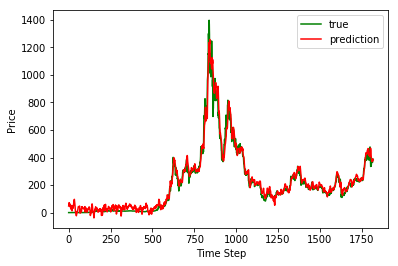

In [72]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="true")
plt.plot(np.arange(0, len(y_train)), predicted_price, 'r', label="prediction")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

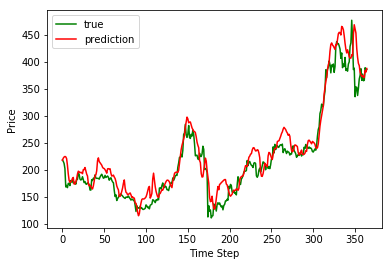

In [73]:
plt.plot(np.arange(0, 365), y_train[-365:], 'g', label="true")
plt.plot(np.arange(0, 365), predicted_price[-365:], 'r', label="prediction")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

### Test des Modells
Nachdem das Modell nun trainiert ist, kann mit den Testdaten überprüft werden, wie gut das Modell funktioniert. Das Diagramm zeigt dabei in blau den tatsächlichen Preisverlauf während der Testphase ab und in rot den vom Modell vorhergesagten Preisverlauf während der Testphase.

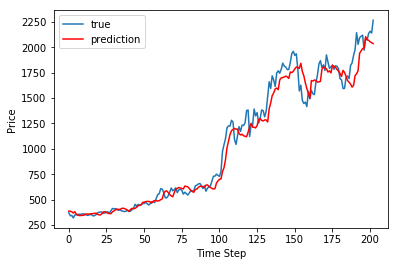

In [74]:
predicted_price = model.predict(X_test)
predicted_price = y_scaler.inverse_transform(predicted_price)
y_train_inv = y_scaler.inverse_transform(y_train)
y_test_inv = y_scaler.inverse_transform(y_test)
predicted_price

plt.plot(y_test_inv, label="true")
plt.plot(predicted_price, 'r', label="prediction")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

@aaron

## 3. Auführung

## Anwenden auf Twitter Livedaten

Da die Sentimentanalyse lediglich eine Ergänzung zu der technischen Analyse ist müssen die Ergebnisse entsprechend aufbereitet werden.

Um die Tweets zu fetchen wird `searchtweets` verwendet. Weiterhin wird wieder Matplotlib verwendet, um die Ergebnisse graphisch darzustellen.

In [75]:
# pip install searchtweets-v2
from searchtweets import load_credentials, gen_request_parameters, collect_results
from datetime import datetime
import matplotlib.dates as mdate
import math

Hier laden wir den Token für die Twitter API, dieser sollte sich im Rootordner des Projekts liegen.

In [76]:
search_args = load_credentials("./.twitter_keys.yaml", yaml_key="search_tweets_v2")

Hier definieren wir unsere Queryparameter. Wir laden 100 Tweets, was das Maximum für einen einzelnen API Request ist und geben an, dass alle Tweets mit den Keywords "ether", "eth", "ethereum" oder "cryptocurrency" gefetcht werden sollen. Weiterhin filtern wir Tweets von Bots heraus und Tweets, die das Wort "app" enthalten, da dies meist nur Werbung ist. Zusätzlich müssen die Nutzer verifiziert sein und die Sprache englisch.

In [77]:
max_tweets = 100

query = gen_request_parameters(
    "(ether OR eth OR ethereum OR cryptocurrency) -bot -app -is:retweet is:verified lang:en",
    tweet_fields="id,created_at,text,public_metrics",
    results_per_call=max_tweets)

Mit `collect_results()` fetchen wir nun die Tweets und reversen sie, da sie hier für uns falschrum ankommen (neuester Tweet kommt hier zuerst). Mit `pop()` entfernen wir das erste Element, da es sich hier um ein Informationsobjekt handelt. Weiterhin filtern wir die für uns relevanten Informationen heraus wie Datum und Text.

In [78]:
tweets = list(reversed(collect_results(query, max_tweets=max_tweets, result_stream_args=search_args)))

tweets.pop(0)

print(tweets[0])

create_dates = []
tweet_texts = []

for tweet in tweets:
    if 'text' not in tweet:
        continue
    tweet_texts.append(tweet['text'])
    
    utc_time = datetime.strptime(tweet['created_at'], "%Y-%m-%dT%H:%M:%S.%fZ")
    epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
    create_dates.append(epoch_time)

{'text': 'When #Nvidia gamer customers complained in Feb over GPU supply shortage due to #CryptoMining they announced production &amp; sale of #Cryptocurrency #Eth Mining Processors - &amp; now estimate $150M in rev for its #crypto product!\n\n#eTorox\nhttps://t.co/w7XebmHu6l\nhttps://t.co/9rsWLCFFhr', 'id': '1381950294372798467', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'created_at': '2021-04-13T12:40:00.000Z'}


Hier übergeben wir unseren Sentimentmodel den Batch an gefetchten Tweets. Dannach formatieren wir noch das Sentiment, sodass es von -1 bis 1 geht. Somit kann man besser unterscheiden, ob Tweets negativ oder positiv gemeint sind.

In [79]:
raw_sentiment = sentiment_model.predict(tweet_texts).flatten()

sentiment = []

for s in raw_sentiment:
    sentiment.append((s - 0.5) * 2)

for i in range(5):
    d = create_dates[i]
    t = tweet_texts[i]
    p = sentiment[i]
    print("{} - {} - {}".format(d,t,p))

1618317600.0 - When #Nvidia gamer customers complained in Feb over GPU supply shortage due to #CryptoMining they announced production &amp; sale of #Cryptocurrency #Eth Mining Processors - &amp; now estimate $150M in rev for its #crypto product!

#eTorox
https://t.co/w7XebmHu6l
https://t.co/9rsWLCFFhr - 0.015010833740234375
1618317900.0 - Today's newsletter is out: A.J. Hinch gets easy redemption, the A's president talks about paying players in cryptocurrency, Bill James and Jon Heyman are both full of shit, and West Virginia wants to pay you to move there.  https://t.co/QtanjfqbjI - -0.1930304765701294
1618318055.0 - It's not every day I get to talk to one of crypto's leading news publications @Cointelegraph in an interview, but when I do, I talk markets!

Find out my thoughts on the $ETH, $XRP controversies, alt season, and my price predictions in this new blog post!

https://t.co/meCeS3iopd - -0.4473927617073059
1618318221.0 - Bitcoin, the world’s largest cryptocurrency, was at $62,

Da wir den aktuellen Sentimenttrend bestimmen wollen implementieren wir eine Simple Moving Average

In [80]:
def simple_moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[n:] - cumsum[:-n]) / float(n)

Nun plotten wir das Sentiment in einen Zeitgraphen. Hier können wir bereits erkennen, wir die aktuelle Marktstimmung der letzten Stunden aussieht

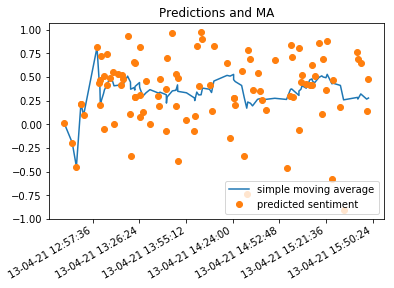

In [81]:
n = 10
sma = simple_moving_avg(sentiment, n)

for i in range(n - 1):
    sma = np.insert(sma, i, sentiment[i])
    
dates = mdate.epoch2num(create_dates)

fig, ax = plt.subplots()

ax.plot(dates, sma, label="simple moving average")
ax.plot(dates, sentiment, "o", label="predicted sentiment")

date_fmt = '%d-%m-%y %H:%M:%S'

date_formatter = mdate.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)

fig.autofmt_xdate()

plt.title('Predictions and MA')
plt.legend(loc='lower right')

plt.show()

Wir wollen aber zusätzlich noch den Einfluss der Tweets miteinberechnen. Dafür gewichten wir die Tweets mithilfe der Anzahl der Likes. Dafür mulitplizieren wir die Anzahl der Likes mit dem Sentiment Wert (+1 da sonst alle Tweets mit 0 Likes eliminiert werden). Mit den Sigmoid Funktion squashen wir alle Werte zurück in unseren vorherigen Wertebereich.

In [82]:
weighted_sentiment = []

def normalized_sigmoid(x):
  return ((1 / (1 + math.exp(-x))) - 0.5) * 2

for i in range(len(sentiment)):
    if 'public_metrics' not in tweets[i]:
        weight = 1
        weighted_sentiment.append(sentiment[i])
    else:
        weight = tweets[i]['public_metrics']['like_count'] + 1
        weighted_sentiment.append(normalized_sigmoid(weight * sentiment[i]))


Nun können wir die gewichtete Marktstimmung erneut ausgeben

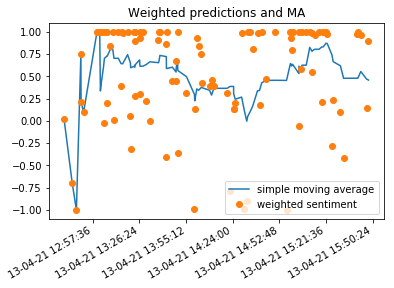

In [83]:
n = 10
weighted_sma = simple_moving_avg(weighted_sentiment, n)

for i in range(n - 1):
    weighted_sma = np.insert(weighted_sma, i, weighted_sentiment[i])
    
dates = mdate.epoch2num(create_dates)

fig, ax = plt.subplots()

ax.plot(dates, weighted_sma, label="simple moving average")
ax.plot(dates, weighted_sentiment, "o", label="weighted sentiment")

date_fmt = '%d-%m-%y %H:%M:%S'

date_formatter = mdate.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)

fig.autofmt_xdate()

plt.title('Weighted predictions and MA')
plt.legend(loc='lower right')

plt.show()

Letztendlich können wir die beiden Werte noch vergleichen, um zu überprüfen, ob die Gewichtung tatsächlich einen Einfluss auf den Stimmungstrend hat

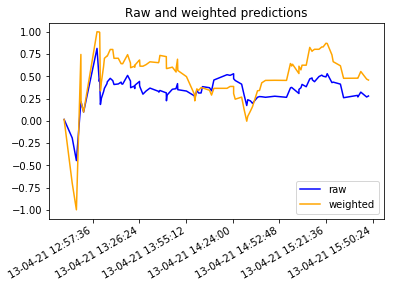

In [84]:
dates = mdate.epoch2num(create_dates)

fig, ax = plt.subplots()

ax.plot(dates, sma, label="raw", color='blue')
ax.plot(dates, weighted_sma, label="weighted", color='orange')

date_fmt = '%d-%m-%y %H:%M:%S'

date_formatter = mdate.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)

fig.autofmt_xdate()

plt.title('Raw and weighted predictions')
plt.legend(loc='lower right')

plt.show()

Die folgende Funktion dient zur Datenaufbereitung für die Vorhersage des Kursverlaufes 30 Tage in die Zukunft.

In [85]:
def create_data(df, X_scaler_predict, y_scaler_predict):
    kama_indicator = KAMAIndicator(close = df["price"], window = 10, pow1 = 2, pow2 = 30, fillna = False)
    df['kama'] = kama_indicator.kama()
    ppo_indicator = PercentagePriceOscillator(close = df["price"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
    df['ppo'] = ppo_indicator.ppo()
    roc_indicator = ROCIndicator(close = df["price"], window = 12, fillna = False)
    df['roc'] = roc_indicator.roc()
    macd_indicator = MACD(close = df["price"], window_slow = 20, window_fast = 12, window_sign = 9, fillna = False)
    df['macd'] = macd_indicator.macd()
    rsi_indicator = RSIIndicator(close = df["price"], window = 14, fillna = False)
    df['rsi'] = rsi_indicator.rsi()
    aroon_indicator = AroonIndicator(close = df["price"], window = 20, fillna = False)
    df['aroon'] = aroon_indicator.aroon_indicator()
    boll_indicator = BollingerBands(close = df["price"], window = 20, window_dev = 2, fillna = False)
    df['boll_mavg'] = boll_indicator.bollinger_mavg()
    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    prices = df['price'].to_numpy()
    
    increase = []
    for i in range(0, len(df)):
        if(i == len(prices)-1):
            increase.append(1)
        else:
            if(prices[i+1] > prices[i]):
                increase.append(1)
            else:
                increase.append(0)
    df['increase'] = increase

    df_new = df.tail(batch_size)
    predict = df_new.iloc[:len(df_new)]
    

    X_predict = predict.filter(X_columns)
    y_predict = predict.filter(['price'])

    X_scaled_predict = X_scaler_predict.fit_transform(X_predict)
    y_scaled_predict = y_scaler_predict.fit_transform(y_predict)

    X_scaled_predict = pd.DataFrame(data=X_scaled_predict, index=predict.index, columns=X_columns)
    y_scaled_predict = pd.DataFrame(data=y_scaled_predict, index=predict.index, columns=['price'])
    
    return df, X_scaled_predict, y_scaled_predict

### Vorhersage des Kurses 30 Tage in die Zukunft
Für die Vorhersage werden die Daten der letzten 81 Tage abgefragt, anschließend werden wieder alle Indicatoren hinzugefügt. Danach wird der Datensatz wieder auf 31 Einträge gekürzt (wie Batch-Größe) und eine Vorhersage für den nächsten Tag gemacht. Anhand von dem vorhergesagten Preis müssen mit der Funktion oben wieder die verschiedenen Indikatoren berechnet und die Daten in das richtige Format gebracht werden. Danach wird wieder eine Vorhersage für den nächsten Tag gemacht und dies wiederholt sich 30 mal und am Ende ist ein Diagramm mit der Vorhersage für die nächsten 30 Tage zu sehen. 

In [86]:
end = datetime.today()
start = datetime.today() - timedelta(days=batch_size + 50)
ETH = pdr.DataReader(symbol,'yahoo',start,end)

df = pd.DataFrame(data=ETH)
df =  df.drop(df.columns[[0, 1, 2, 4, 5]], axis=1)
df.rename(columns = {"Close": "price"}, inplace=True)
prices = df['price'].to_numpy()

X_scaler_predict = MinMaxScaler(feature_range = (0, 1))
y_scaler_predict = MinMaxScaler(feature_range = (0, 1))

days_in_future = 30
y_predicted_all = []

for i in range(days_in_future):
    df, X_scaled_predict, y_scaled_predict = create_data(df, X_scaler_predict, y_scaler_predict)
    X = np.array([X_scaled_predict.values])
    y_predicted = model.predict(X)
    y_predicted_inv = y_scaler_predict.inverse_transform(y_predicted)
    y_predicted_all.append(y_predicted_inv[0][0])
    del X_scaled_predict
    del y_scaled_predict
    
    add_index = pd.Index([(datetime.today())+ timedelta(days=1)])
    add_index.set_names('Date', inplace=True)
    df2 = pd.DataFrame(index = add_index, data=([[y_predicted_inv[0][0], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0]]), columns=X_columns)
    df = df.append(df2)
    del y_predicted
    del y_predicted_inv

print(y_predicted_all)

[2092.2715, 2073.6265, 2063.6436, 2057.164, 2052.5066, 2050.6074, 2051.2395, 2053.5042, 2056.1667, 2060.7139, 2065.2168, 2071.6477, 2080.609, 2088.301, 2096.2368, 2109.2986, 2122.8496, 2138.9326, 2147.1602, 2159.994, 2167.4915, 2176.7798, 2185.1917, 2192.2021, 2198.481, 2203.2542, 2207.3948, 2209.821, 2212.1824, 2213.046]


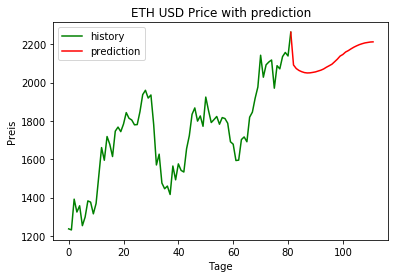

In [87]:
plt.plot(np.arange(0, len(prices)), prices, 'g', label="history")
plt.plot(np.arange(len(prices) - 1, len(prices) + len(y_predicted_all)), [prices[-1]] + y_predicted_all, 'r', label="prediction")
plt.title('ETH USD Price with prediction')
plt.xlabel('Tage')
plt.ylabel('Preis')
plt.legend()

plt.show()

#### Herausforderungen bei einem produktiven Einsatz der Modelle

Nachdem die ersten Vorhersagen mit einem Modell getroffen wurde, stellt sich auch die Frage, wie diese Modelle nun innerhalb einer produktiven Umgebung eingesetzt werden können.
Dabei stellen sich einige Herausforderungen:

1. **Wie werden die Modelle bereitgestellt?:**
Es muss eine API programmiert werden, die entsprechende Endpunkte bereitstellt, um mit den Modellen zu interagieren.

2. **Welche Anforderungen können an die API gestellt werden?:**
Es gilt weiterhin zu untersuchen, ob und inwiefern Parameter bei der bisherigen Nutzung des Modells *hardgecodet* wurden, die nun extrahiert und konfigurierbar gemacht werden müssen, sodass eine nutzerindividuelle Anfrage möglich ist.

3. **Datentransformation:**
Die Datentransformation, die während des Trainings und den initialen Vorhersagen durchgeführt wurde muss auch entsprechend der Live-Datenquelle durchgeführt werden. Das bedeutet, evtl. Aufwändige Datenebereinigung oder Vorbereitungen für das Modell müssen innerhalb der API durchgeführt werden. So stellen sich evtl. neue Anforderungen an das Modell, damit Transformationen nicht zu aufwändig sind, um eine Responsivität der API zu gewährleisten.

Zusammenfassend lässt sich sagen, dass es einige Aufgaben zu erledigen gilt, bevor ein trainiertes ML-Modell produktiv genutzt werden kann.